# Classification of lesions in medical physics 

The aim of this exercise is to create and train a simple convolutional neural network (CNN) for deep-learning based classification of normal tissue vs. tissue cointaining microcalcification clusters in mammograms. 

In this exercise you will learn how to: 

*   Load and explore image data.
*   Define the CNN model.
*   Compile and train the CNN model on the training data.  
*   Predict the labels of the test data and calculate the classification accuracy. 
*   Create the ROC curve and calculate the AUC.

Moreover if you want, you will learn how to perform data augmentation. 

## Description of the dataset

The dataset we will use contains many image portions (60x60 pixels) extracted from real mammograms converted to 8-bit grayscale images. These images can either contain microcalcification clusters (label=1) or  normal breast tissue (label=0).


The available images are already partitioned in a train and a test sets, containing, respectively:
- Train set (70% of the whole sample): 289 images with normal tissue and 267 images with microcalcification clusters;  
- Test set (30% of the whole sample): 125 images with normal tissue and 116 images with microcalcification clusters. 

The test set should always be left apart from the training procedure and used as an independent set to evaluate the classifier performance.


## Remark
The architecture of the CNN you will develop in this exercise can be trained on different kind of 2D images (with 1 color channel) even outside the medical imaging domain. 



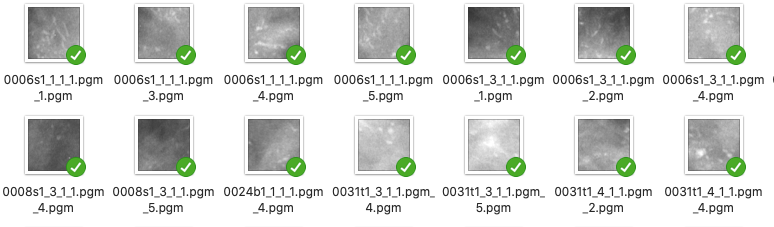

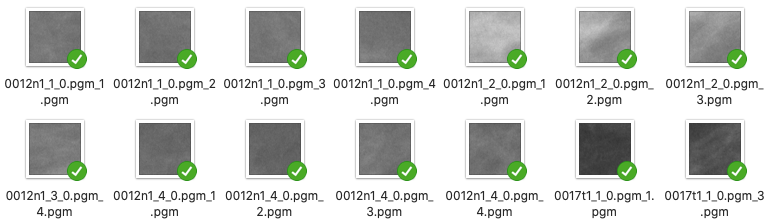

# Importing the dataset from Google Drive


Data is in this folder: https://drive.google.com/drive/folders/1bru5aQX9u6cECmrGHd723WhiIjD_InK9?usp=sharing

BUT, in order to make things easier here, we use a zip file from a web server



In [ ]:
import os
if not os.path.isfile('Mammography_micro-20210526T120107Z-001.zip'):
 !wget http://www.pi.infn.it/~boccali/Mammography_micro-20210526T120107Z-001.zip
 !unzip Mammography_micro-20210526T120107Z-001.zip

Using the special ```!``` charcter we can execute shell commands. For example we can show all file and folders in a certain path with ```ls```.





In [ ]:
!ls Mammography_micro

Each folder should have mammogram images containing microcalcifications (label=1) or normal breast tissue (label=0) put in different subfolders.

The number of images for each folder should be as it follows:
```
Train 0 files: 289
Train 1 files: 267
Test 0 files: 125
Test 1 files: 116
```



In [ ]:
!echo -n "Train 0 files: "; ls Mammography_micro//Train/0 | wc -l;
!echo -n "Train 1 files: "; ls Mammography_micro//Train/1 | wc -l;
!echo -n "Test 0 files: "; ls Mammography_micro//Test/0 | wc -l;
!echo -n "Test 1 files: "; ls Mammography_micro//Test/1 | wc -l;

Print the filename structure inside a folder.

In [ ]:
!ls Mammography_micro/Train/1/ | tail -n 3

# Reading the images

Importing python packages



In [ ]:
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import glob
import numpy as np

Let's try to read an image with ```imread``` [[doc](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread)]. The output is a 2D array (since the image is in grayscale).
We can view the image through the package ```imshow``` of matplotlib [[doc](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html)].

In [ ]:
sample_img = imread('Mammography_micro/Train/1/0006s1_1_1_1.pgm_1.pgm')
print("Shape of array:", np.shape(sample_img))
plt.imshow(sample_img, cmap='gray')

We define a function to read images from a certain ```dataset_path``` and ```classes``` that match the subfolders containing labeled images.

The function uses the ```glob``` functions that finds all the pathnames that match a given pattern [[doc](https://docs.python.org/3/library/glob.html)].
The images are read though the package ```imread``` [[doc](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread)]. This list of read images is populated with list comprehensions [[doc](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions)].

The last line converts the ```tmp``` list into a numpy array storing float32 data, adding an extra dimension with ```np.newaxis``` [[doc](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis)] (the three dots ```...``` are a special indexing symbol called ellipsis [[doc](https://docs.python.org/dev/library/constants.html#Ellipsis)])

In [ ]:
def read_imgs(dataset_path, classes):
  tmp = []
  labels = []
  for cls in classes:
    # Returns all the images filenames contained in a certain folder
    fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.pgm'))
    # Read, with a list comprehension, all the images listed before
    tmp += [ imread(fname) for fname in fnames ]
    # Populate the labels list with the label of the read image
    labels += len(fnames)*[cls]
 
  return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)

In [ ]:
train_dataset_path = 'Mammography_micro/Train'
x_train, y_train = read_imgs(train_dataset_path, [0, 1])

test_dataset_path = 'Mammography_micro/Test'
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

It's always a good idea to print the shape of the array in use. In our case the first dimension is the number of read images, the second and the third are the dimension of the images, and the last one is the auxiliary axis we created.

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
#plot the first image in the dataset
img_1 = x_train[0].reshape(60,60)
plt.imshow(img_1, cmap='gray')

# Defining a CNN model

Convolutional neural networks (CNN) are a class of neural network usually used to classify images.
[Ref1](https://www.asimovinstitute.org/neural-network-zoo/) 
[Ref2](https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/)

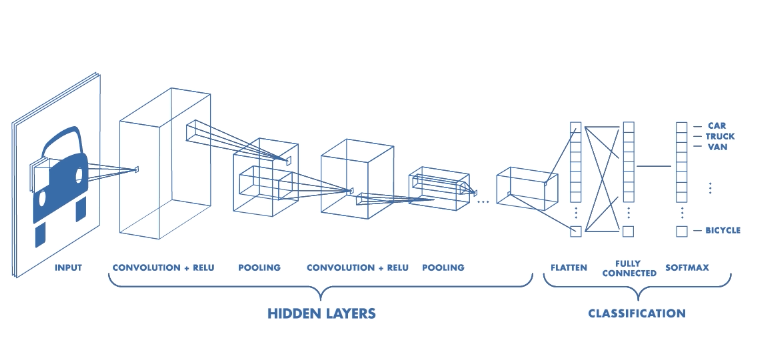

[Ref3](https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5)


- In CNN, the convolutional layers nodes are not connected to all the nodes of previous layer. This is due to the high dimesionality of image data. For this reason we connect each node only to a local region of the input. 

- The nodes are called neurons or filter or kernel. The nodes/filters are convolved to the network layers and they slide through the whole image in order to cover all pixels.

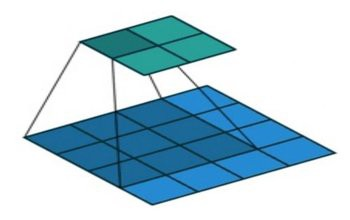

- Pooling layers. Pooling is a way to downsample the image: a common pooling technique is the "max pooling". A max pooling layer takes, for example, a 2x2 submatrix and returns the pixel with the maximum value.




The Keras library in Python makes it pretty simple to build a CNN.
- Sequential is the easiest way to build a model in Keras. It allows you to build a model layer by layer.

- Convolution layer
> - The first layer takes in an input shape. This is the shape of each input image. In this case, it is (60,60,1).
> - Number of nodes in each layer (8,16,32) 
> - Kernel size is the size of the filter matrix for our convolution. So a kernel size of 3 means we will have a 3x3 filter matrix.
> - What is the effect of using "padding = same"? 
> - Activation is the activation function for the layer. (ReLU or Rectified Linear Activation has been proven to work well in neural networks)

- 'Batch normalization' adds a ‘normalization layer’ after each convolutional layer. This allows the model to converge much faster in training and to generalize better.

- ‘Dense’ is the layer we will use just before the output layer. It is a fully connected layer typical of a Multi Layer Perceptrons model.

- The last layer contains 1 node and a different activation function called "sigmoid". The sigmoid returns a probability distribution in the range of 0 to 1 (it is not the only one!!!). Why is there just 1 node? Is it possible to use another number of nodes? 

---
To prevent over-fitting we will use dropout layers. 
Overfitting happens when your model fits too well to the training set. It then becomes difficult for the model to generalize. 
Dropout works by stochastically removing, or “dropping out,” some nodes.




In [ ]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1)
print(np.shape(X_train), np.shape(Y_train))
print(np.shape(X_val), np.shape(Y_val))

In [ ]:
#modello 1
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(8, (3,3), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),

      MaxPool2D((2,2), strides=2),
      #Dropout(0.4),

      Conv2D(16, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      MaxPool2D((2,2), strides=2),
      #Dropout(0.4),

      Conv2D(32, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),

      MaxPool2D((2,2), strides=2),
      #Dropout(0.4),

      Flatten(),    #Flatten serves as a connection between the convolution and dense layers.

      Dense(10, activation='relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
     
  ])
  return model


In [ ]:
'''
#VGG
def vgg(shape=(60, 60, 1)):
  model = Sequential([
      Conv2D(8, (3,3), padding='same', input_shape=shape),
      Activation('relu'),
      Conv2D(8, (3,3), padding='same'),
      Activation('relu'),               

      MaxPool2D((2,2), strides=2),

      Conv2D(16, (3,3), padding='same'),
      Activation('relu'),    
      Conv2D(16, (3,3), padding='same'),
      Activation('relu'),    

      MaxPool2D((2,2), strides=2),

      Conv2D(32, (3,3), padding='same'),
      Activation('relu'),    
      Conv2D(32, (3,3), padding='same'),
      Activation('relu'),    

      MaxPool2D((2,2), strides=2),

      Flatten(),
      Dense(10, activation='relu'),
      Dense(1, activation='softmax')
  ])
  return model
  '''

The output of each Conv2D and MaxPooling2D layer is a 3D shape tensor (height, width, channels). The size of width and height tends to decrease. The number of output channels for each Conv2D layer is controlled by the first argument (32 or 64).

In [ ]:
model = make_model()
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Next, we need to compile our model. Compiling the model takes three parameters: optimizer, loss and metrics.
- The loss function ‘binary_crossentropy’ is the most common choice for classification and represents the function we want to minimize.
- The optimizer is the algorithm procedure for minimizing the loss. A pivotal parameter of the optimizer is the learning rate which is the step size made by the loss function towards its minimum.

- We will use the ‘accuracy’ metric to measure the model classification performance on both the validation set (during training) and the test set.

In [ ]:
from keras.optimizers import SGD #stochastic gradient descent
epochs=100
learning_rate = 0.001
model.compile(optimizer=SGD(lr=learning_rate, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc). 
[doc](https://keras.io/api/callbacks/)



In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

To train the model, we will use the ‘fit()’ function with the following parameters: training data (x_tain), target data (y_train), validation data, and the number of epochs.


In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch = np.shape(X_train)[0]/batch_size,
                    verbose=1,
                    validation_data=(X_val, Y_val),
                    validation_steps=np.shape(X_val)[0]/batch_size,
                    callbacks=[checkpoint,reduce_on_plateau])         

Evaluate the network performance on train data

In [ ]:
_, train_acc = model.evaluate(x_train, y_train, verbose=0)
print('Train accuracy: %.3f' % (train_acc))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Save the trained model 

In [ ]:
!mkdir content
model.save('content/model.hdf5')

In [ ]:
!ls

Evaluate network performance on test data in term of accuracy.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Create the ROC curve and AUC (compute the false-positive rate and the true-positive rate)


In [ ]:
from sklearn.metrics import roc_curve, auc
preds = model.predict(x_test, verbose=1)

fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Data augmentation
To perform data augmentation with ImageDataGenerator, we need to convert the PGM format to PNG.

In [ ]:
import PIL
import os

In [ ]:
def convert_to_png(fname, dest_folder):
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  dest_fname = os.path.join(dest_folder, dest_fname)
  PIL.Image.open(fname).convert('L').save(dest_fname)


In [ ]:
for data_path in ['Mammography_micro/Train', 'Mammography_micro/Test']:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)


In [ ]:
!ls Mammography_micro/Test_png/

Data augmentation is a process of artificially creating new training data from the existing one. This is particularly useful in medical physics since data is usually scarce. Data augmentation relies on the ImageDataGenerator class of keras
[[doc](https://keras.io/api/preprocessing/image/)]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dataset_path = 'Mammography_micro/Train_png'
img_width, img_height = (60, 60)

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        #rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.18,
        horizontal_flip=True,
        #vertical_flip=True,
        fill_mode='reflect', #  nearest?
        validation_split=0.3)
        
train_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')


In [ ]:
train_gen.next()[0].shape

In [ ]:
plt.imshow(train_gen.next()[0][1].squeeze(), cmap='gray')

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [ ]:
model = make_model()
epochs=100
learning_rate = 0.001
decay_rate = learning_rate / epochs
model.compile(optimizer=SGD(lr=learning_rate, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
history = model.fit(train_gen,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch = 278//batch_size,
                    verbose=1,
                    validation_data=val_gen,
                    validation_steps=118//batch_size,
                    callbacks=[checkpoint, reduce_on_plateau])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Saving the model

In [ ]:
!ls content

In [ ]:
model.save('content/model_augmented.hdf5')

In [ ]:
from keras.models import load_model

In [ ]:
imported_model = load_model('content/model_augmented.hdf5')

In [ ]:
imported_model.summary()

# Evaluate the performances of the two models

In [ ]:
noaug_model = load_model('content/model.hdf5')
aug_model = load_model('content/model_augmented.hdf5')

In [ ]:
x_test, y_test = read_imgs('Mammography_micro/Test', [0,1])

In [ ]:
test_loss_noaug, test_acc_noaug = noaug_model.evaluate(x_test, y_test)
print('\nTest accuracy noaug_model:', test_acc_noaug)

In [ ]:
test_loss_aug, test_acc_aug = aug_model.evaluate(train_gen)
print('\nTest accuracy aug_model:', test_acc_aug)